DataLoaders created successfully!

Epoch 1/3


Train Loss: 0.5859 | Val Loss: 0.5445 | Dice Score: 0.1825

Epoch 2/3


Train Loss: 0.5394 | Val Loss: 0.4923 | Dice Score: 0.4188

Epoch 3/3


Train Loss: 0.4704 | Val Loss: 0.3990 | Dice Score: 0.6586

Training finished!


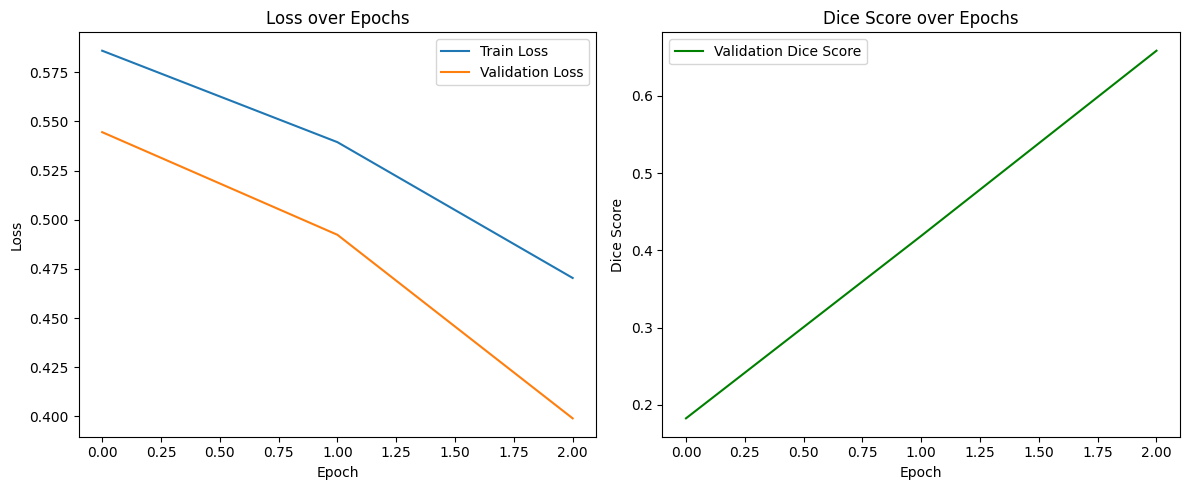

In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

class OxfordPetSegmentation(Dataset):
    def __init__(self,root,split='train',transform=None,target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        #Fallback
        if os.path.exists(os.path.join(root, "annotations", f"{split}.txt")):
            with open(os.path.join(root, "annotations", f"{split}.txt"), "r") as f:
                self.image_ids = [line.strip().split()[0] for line in f]
        else:
            self.image_ids = [f.split('.')[0] for f in os.listdir(os.path.join(root, "images")) if f.endswith(".jpg")]


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self,idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root, "images", f"{img_id}.jpg")
        mask_path = os.path.join(self.root, "annotations", "trimaps", f"{img_id}.png")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

# U-Net Model

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),  
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self,in_channels=3,out_channels=1, features=[64,128,256,512]):
        
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                skip_connection = TF.center_crop(skip_connection, output_size=x.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)

    
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.PILToTensor(),  # Keeps values in [0,1,2]
    transforms.Lambda(lambda x: torch.where(x == 1, 1.0, 0.0))  # Map '1' to pet, rest to 0
])

train_dataset = OxfordPetSegmentation(
    root="./data/oxford-iiit-pet",
    split="trainval",
    transform=image_transform,
    target_transform=target_transform
)

test_dataset = OxfordPetSegmentation(
    root="./data/oxford-iiit-pet",
    split="test",
    transform=image_transform,
    target_transform=target_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("DataLoaders created successfully!")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
NUM_EPOCHS = 3

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.99)



import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assume these are already defined above:
# - train_loader
# - test_loader
# - model
# - DEVICE
# - loss_fn
# - optimizer

train_losses = []
val_losses = []
val_dice_scores = []

def dice_score(preds, targets, threshold=0.5, epsilon=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    
    dice = (2 * intersection + epsilon) / (union + epsilon)
    return dice.mean()

# ----------------------------
# Training Function with tqdm
# ----------------------------
def train_fn(loader, model, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    loop = tqdm(loader, desc="Training", leave=False)
    
    for data, targets in loop:
        data = data.to(DEVICE)
        targets = targets.float().to(DEVICE)

        preds = model(data)
        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return running_loss / len(loader)

# ----------------------------
# Validation Function
# ----------------------------
def eval_fn(loader, model, loss_fn):
    model.eval()
    val_loss = 0.0
    dice = 0.0

    with torch.no_grad():
        loop = tqdm(loader, desc="Validation", leave=False)
        for data, targets in loop:
            data = data.to(DEVICE)
            targets = targets.float().to(DEVICE)

            preds = model(data)
            loss = loss_fn(preds, targets)
            val_loss += loss.item()

            dice += dice_score(preds, targets).item()
            loop.set_postfix(loss=loss.item())

    return val_loss / len(loader), dice / len(loader)

# ----------------------------
# Training Loop with Eval
# ----------------------------
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

    train_loss = train_fn(train_loader, model, optimizer, loss_fn)
    val_loss, val_dice = eval_fn(test_loader, model, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Dice Score: {val_dice:.4f}")

print("\nTraining finished!")

# ----------------------------
# Plotting Loss and Dice Score
# ----------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_dice_scores, label="Validation Dice Score", color="green")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.title("Dice Score over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

    